<a href="https://colab.research.google.com/github/inuwamobarak/KOSMOS-2/blob/main/KOSMOS_2_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Python script demonstrates how to perform inference with Microsoft's multimodal large language model, KOSMOS-2, for multimodal grounding and referral.

You can also find the original Colab notebook from https://github.com/NielsRogge at https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/KOSMOS-2/Inference_with_KOSMOS_2_for_multimodal_grounding.ipynb

In this script, we'll walk through several steps to showcase KOSMOS-2's capabilities.

## Step 1: Set Up Environment
In this step, we install necessary dependencies like 🤗 Transformers, Accelerate, and Bitsandbytes. These libraries are crucial for efficient inference with KOSMOS-2.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git accelerate bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.5 MB/s eta 0:00:00



## Step 2: Load KOSMOS-2 Model
Next, we load the KOSMOS-2 model and its processor.

In [15]:
# !cd /Volumes/blockdata/ai/models

from transformers import AutoProcessor, AutoModelForVision2Seq
import torch

# 检查 MPS 是否可用
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

processor = AutoProcessor.from_pretrained("/Volumes/blockdata/ai/models/kosmos2/")
model = AutoModelForVision2Seq.from_pretrained("/Volumes/blockdata/ai/models/kosmos2/", device_map={"": device})

model = model.to(device)

Using device: mps


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Step 3: Load Image and Prompt
In this step, we demonstrate image grounding. We load an image and provide a text prompt for the model to complete. We use the special `<grounding>` token, which is crucial for referencing objects in the image.

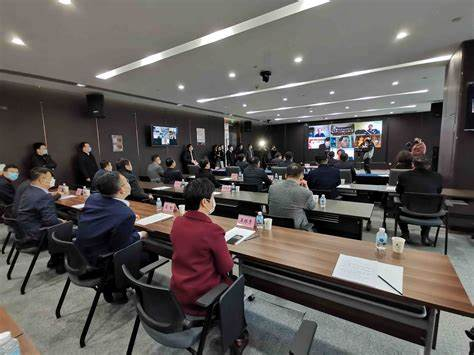

In [30]:
import requests
from PIL import Image

prompt = "<grounding>An image of"
prompt = "<grounding> Question: How many people are in this image? Answer:"
prompt = "<grounding> Question: How many cat are in this image? Answer:"
# url = "https://hf-mirror.com/microsoft/kosmos-2-patch14-224/resolve/main/snowman.png"
url = "https://tse3-mm.cn.bing.net/th/id/OIP-C.UfH-QuSzFmt5UBT6soE10gHaFj?rs=1&pid=ImgDetMain"
image = Image.open(requests.get(url, stream=True).raw)
# image = Image.open("/Volumes/blockdata/ai/models/kosmos2/snowman.png")

image

## Step 4: Generate Completion
Next, we prepare the image and text prompt for the model using the processor. We then let the model autoregressively generate a completion. The generated completion provides information about the image and its content.

In [31]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to("mps")
# inputs = processor(text=prompt, images=image, return_tensors="pt").to("cuda:0")

# Autoregressively generate completion
generated_ids = model.generate(**inputs, max_new_tokens=128)
# Convert generated token IDs back to strings
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

## Step 5: Post-Processing
We look at the raw generated text, which may include some tokens related to image patches. This post-processing step ensures that we obtain meaningful results.

In [32]:
print(generated_text)

<image>. the, to and of as in I that' for is was- on’ it with The as at bet he have from by are " you his “ this said not has an ( but had we her they will my or were their): up about out who one all been she can more would It</image><grounding> Question: How many cat are in this image? Answer:<phrase> A few people</phrase><object><patch_index_0491><patch_index_1009></delimiter_of_multi_objects/><patch_index_0484><patch_index_0874></delimiter_of_multi_objects/><patch_index_0465><patch_index_0661></delimiter_of_multi_objects/><patch_index_0442><patch_index_0734></delimiter_of_multi_objects/><patch_index_0448><patch_index_0773></delimiter_of_multi_objects/><patch_index_0436><patch_index_0599></object>.


## Step 6: Further Processing
In this step, we focus on the generated text beyond the initial image-related tokens. We extract details such as object names, phrases, and location tokens. This extracted information is more meaningful and allows us to understand the model's response better.

In [33]:
# By default, the generated text is cleaned up and the entities are extracted.
processed_text, entities = processor.post_process_generation(generated_text)

print(processed_text)
print(entities)

Question: How many cat are in this image? Answer: A few people.
[('A few people', (50, 62), [(0.359375, 0.484375, 0.546875, 0.984375), (0.140625, 0.484375, 0.328125, 0.859375), (0.546875, 0.453125, 0.671875, 0.640625), (0.828125, 0.421875, 0.953125, 0.703125), (0.015625, 0.453125, 0.171875, 0.765625), (0.640625, 0.421875, 0.734375, 0.578125)])]


In [34]:
end_of_image_token = processor.eoi_token
caption = generated_text.split(end_of_image_token)[-1]
print(caption)

<grounding> Question: How many cat are in this image? Answer:<phrase> A few people</phrase><object><patch_index_0491><patch_index_1009></delimiter_of_multi_objects/><patch_index_0484><patch_index_0874></delimiter_of_multi_objects/><patch_index_0465><patch_index_0661></delimiter_of_multi_objects/><patch_index_0442><patch_index_0734></delimiter_of_multi_objects/><patch_index_0448><patch_index_0773></delimiter_of_multi_objects/><patch_index_0436><patch_index_0599></object>.


## Step 7: Plot Bounding Boxes
We demonstrate how to visualize the bounding boxes of objects identified in the image. This step allows us to understand where the model has located specific objects. We leverage the extracted information to annotate the image.

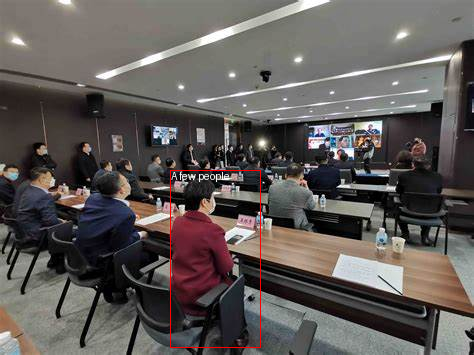

In [35]:
from PIL import ImageDraw

width, height = image.size
draw = ImageDraw.Draw(image)

for entity, _, box in entities:
    box = [round(i, 2) for i in box[0]]
    x1, y1, x2, y2 = tuple(box)
    x1, x2 = x1 * width, x2 * width
    y1, y2 = y1 * height, y2 * height
    draw.rectangle(xy=((x1, y1), (x2, y2)), outline="red")
    draw.text(xy=(x1, y1), text=entity)

image

## Step 8: Grounded Question Answering
KOSMOS-2 allows you to interact with specific objects in an image. In this step, we demonstrate how to prompt the model with a bounding box and a question related to a particular object. The model provides answers based on the context and information from the image.

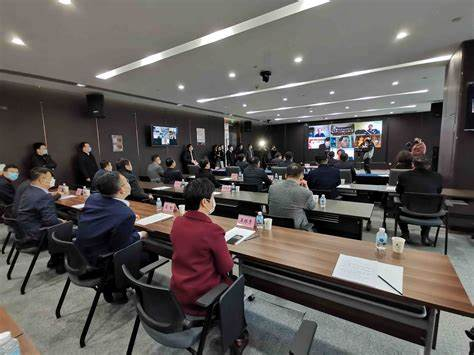

In [16]:
url = "https://hf-mirror.com/ydshieh/kosmos-2-patch14-224/resolve/main/pikachu.png"
# url = "https://tse3-mm.cn.bing.net/th/id/OIP-C.UfH-QuSzFmt5UBT6soE10gHaFj?rs=1&pid=ImgDetMain"
image = Image.open(requests.get(url, stream=True).raw)
image

We can prepare a question and specify a bounding box for Pikachu. The use of special `<phrase>` tokens indicates the presence of a phrase in the question. This step showcases how to obtain specific information from an image using grounded question answering.


In [21]:
prompt = "<grounding> Question: What is<phrase> this character</phrase>? Answer:"
# prompt = "<grounding> Question: How many <phrase> man </phrase> and  <phrase> woman </phrase> and  <phrase> cat </phrase> in the picture? Answer:"
# prompt = "<grounding> Question: How many people are in this image? Answer:"


inputs = processor(text=prompt, images=image, bboxes=[(0.04182509505703422, 0.39244186046511625, 0.38783269961977185, 1.0)], return_tensors="pt").to(device)

ValueError: The number of elements in `bboxes` should be the same as the number of `<phrase> ... </phrase>` pairs in `text`. Got 0 v.s. 1 instead.

## Step 9: Generate Grounded Answer
We allow the model to autoregressively complete the question, generating an answer based on the provided context. Grounded question answering enables us to obtain specific information about objects within an image.

In [18]:
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# By default, the generated text is cleaned up, and the entities are extracted.
processed_text, entities = processor.post_process_generation(generated_text)

print(processed_text)
print(entities)

Question: How many people? Answer: A total of 15 people attended the meeting.
[('people', (19, 25), [(0.046875, 0.390625, 0.390625, 0.984375)])]


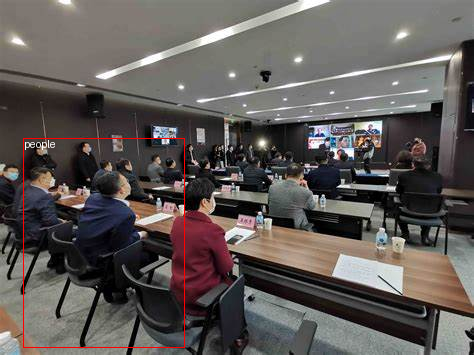

In [19]:
from PIL import ImageDraw

width, height = image.size
draw = ImageDraw.Draw(image)

for entity, _, box in entities:
    box = [round(i, 2) for i in box[0]]
    x1, y1, x2, y2 = tuple(box)
    x1, x2 = x1 * width, x2 * width
    y1, y2 = y1 * height, y2 * height
    draw.rectangle(xy=((x1, y1), (x2, y2)), outline="red")
    draw.text(xy=(x1, y1), text=entity)

image